In [1]:
include("BayesianUtilities/BayesianUtilities.jl")
using Plots, LinearAlgebra, Distributions, Random, ForwardDiff, DelimitedFiles, DataFrames, .BayesianUtilities

In [2]:
Random.seed!(1)
M = [1. -0.4; 0.3 0.8]
eigen(M)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
eigenvalues:
2-element Array{Complex{Float64},1}:
 0.8999999999999999 + 0.33166247903553997im
 0.8999999999999999 - 0.33166247903553997im
eigenvectors:
2×2 Array{Complex{Float64},2}:
 0.755929+0.0im       0.755929-0.0im     
 0.188982-0.626783im  0.188982+0.626783im

In [3]:
T = 15
position = 3*ones(2,T)

for t=2:T
    position[:,t] = M*position[:,t-1]
end

In [4]:
sensor1 = [5.,5.]
sensor2 = [-2.,0.]
sensor3 = [0.,15.]
;

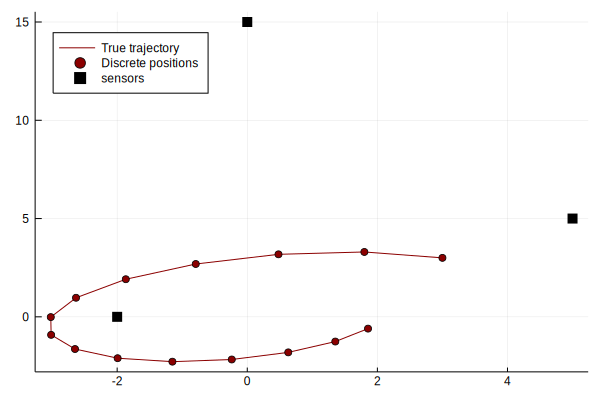

In [5]:
plot(position[1,:],position[2,:],color=:redsblues,legend=:topleft, label="True trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="Discrete positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")

In [6]:
observation = zeros(3,T)

disturbance1 = Normal(0,sqrt(0.2))
disturbance2 = Normal(0,sqrt(0.25))
disturbance3 = Normal(0,sqrt(0.2))

for t=1:T
    o1 = sqrt(sum((position[:,t]-sensor1).^2)) + rand(disturbance1)
    o2 = sqrt(sum((position[:,t]-sensor2).^2)) + rand(disturbance2)
    o3 = sqrt(sum((position[:,t]-sensor3).^2)) + rand(disturbance3)
    obs = [o1,o2,o3]
    observation[:,t] = obs
end

# Model Specification

In [7]:
A = [1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.]
B = [1. 0. 0. 0.; 0. 1. 0. 0.]
p_r = MvNormal(zeros(3),[0.2 0.1 0.1;0.1 0.2 0.1; 0.1 0.1 0.2])
p_z_init = MvNormal(zeros(4),100*diagm(0=>ones(4)))
p_W = Wishart(4,diagm(0=>ones(4)))

function log_likelihood(y,z,r)
    x = B*z
    o1_est = sqrt(sum((x-sensor1).^2))
    o2_est = sqrt(sum((x-sensor2).^2))
    o3_est = sqrt(sum((x-sensor3).^2))
    o_est = [o1_est,o2_est,o3_est]
    R = diagm(0=>exp.(r))
    logpdf(MvNormal(o_est,R),y)
end

log_likelihood (generic function with 1 method)

In [8]:
log_transition(z_new,z_old,W) = logpdf(MvNormal(A*z_old,Matrix(Hermitian(inv(W)))),z_new)

log_transition (generic function with 1 method)

# Inference

In [9]:
q_r = MvNormal(zeros(3),0.1*diagm(0=>ones(3)))
q_W = Wishart(4,diagm(0=>ones(4)))
q_z = Array{MvNormal,1}(undef, T)
for t=1:T q_z[t] = MvNormal(zeros(4),diagm(0=>ones(4))) end
;

In [10]:
function Low(param)
    [param[5] 0 0 0; param[6] param[7] 0 0; param[8] param[9] param[10] 0; param[11] param[12] param[13] param[14]]
end

Low (generic function with 1 method)

In [11]:
# approximate q(z_1)
function approx_z1(obs::Array,q_z_new::MvNormal,q_r::MvNormal,q_W::Wishart,η::Number,n_its::Number,S::Number)
    grad_past = zeros(14) # 4 mean, 10 for L
    G = zeros(14,14)
    param = rand(14)
    for n=1:n_its
        grad_tot = zeros(14)
        CVf, CVh = zeros(14,S), zeros(14,S) # required for control variates
        for s=1:S
            L = Low(param)
            V = L*L'
            z_s = rand(MvNormal(param[1:4],V))
            log_q(param) = logpdf(MvNormal(param[1:4],Low(param)*Low(param)'),z_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            r_s, W_s, z_new_s = rand(q_r), rand(q_W), rand(q_z_new)
            grad_s = grad_log_q.*(logpdf(MvNormal(param[1:4],V),z_s) - logpdf(p_z_init,z_s)
                                  - log_likelihood(obs,z_s,r_s) - log_transition(z_new_s,z_s,W_s))
            CVf[:,s] = grad_s #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_s
        end
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(14,)))./S
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        param = param .- step_size .* grad
    end
    return MvNormal(param[1:4],Low(param)*Low(param)')
end

# approximate q(z_T)
function approx_zT(obs::Array,q_z_old::MvNormal,q_r::MvNormal,q_W::Wishart,η::Number,n_its::Number,S::Number)
    grad_past = zeros(14) # 4 mean, 10 for L
    G = zeros(14,14)
    param = rand(14)
    for n=1:n_its
        grad_tot = zeros(14)
        CVf, CVh = zeros(14,S), zeros(14,S) # required for control variates
        for s=1:S
            L = Low(param)
            V = L*L'
            z_s = rand(MvNormal(param[1:4],V))
            log_q(param) = logpdf(MvNormal(param[1:4],Low(param)*Low(param)'),z_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            r_s, W_s, z_old_s = rand(q_r), rand(q_W), rand(q_z_old)
            grad_s = grad_log_q.*(logpdf(MvNormal(param[1:4],V),z_s) - logpdf(p_z_init,z_s)
                                  - log_likelihood(obs,z_s,r_s) - log_transition(z_s,z_old_s,W_s))
            CVf[:,s] = grad_s #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_s
        end
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(14,)))./S
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        param = param .- step_size .* grad
    end
    return MvNormal(param[1:4],Low(param)*Low(param)')
end

approx_zT (generic function with 1 method)

In [12]:
# approximate q(z_t) for t=2:T-1
function approx_zt(obs::Array,q_z_new::MvNormal,q_z_old::MvNormal,q_r::MvNormal,q_W::Wishart,η::Number,n_its::Number,S::Number)
    grad_past = zeros(14) # 4 mean, 10 for L
    G = zeros(14,14)
    param = rand(14)
    for n=1:n_its
        grad_tot = zeros(14)
        CVf, CVh = zeros(14,S), zeros(14,S) # required for control variates
        for s=1:S
            L = Low(param)
            V = L*L'
            z_s = rand(MvNormal(param[1:4],V))
            log_q(param) = logpdf(MvNormal(param[1:4],Low(param)*Low(param)'),z_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            r_s, W_s, z_new_s, z_old_s = rand(q_r), rand(q_W), rand(q_z_new), rand(q_z_old)
            grad_s = grad_log_q.*(logpdf(MvNormal(param[1:4],V),z_s) - logpdf(p_z_init,z_s)
                                  - log_likelihood(obs,z_s,r_s) - log_transition(z_new_s,z_s,W_s)
                                  - log_transition(z_s,z_old_s,W_s))
            CVf[:,s] = grad_s #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_s
        end
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(14,)))./S
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        param = param .- step_size .* grad
    end
    return MvNormal(param[1:4],Low(param)*Low(param)')
end

approx_zt (generic function with 1 method)

In [13]:
function Lowr(param)
    [param[4] 0 0; param[5] param[6] 0; param[7] param[8] param[9]]
end

Lowr (generic function with 1 method)

In [14]:
function approx_r(obs_list::Array,q_z::Array{MvNormal},η::Number,n_its::Number,S::Number)
    grad_past = zeros(9) # 3 mean, 6 for L
    G = zeros(9,9)
    param = rand(9)
    for n=1:n_its
        grad_tot = zeros(9)
        CVf, CVh = zeros(9,S), zeros(9,S) # required for control variates
        for s=1:S
            L = Lowr(param)
            V = L*L'
            r_s = rand(MvNormal(param[1:3],V))
            log_q(param) = logpdf(MvNormal(param[1:3],Lowr(param)*Lowr(param)'),r_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            grad_s = logpdf(MvNormal(param[1:3],V),r_s) - logpdf(p_r,r_s)
            for t=1:T
                z_s = rand(q_z[t])
                grad_s -= log_likelihood(obs_list[:,t],z_s,r_s)
            end
            grad_s = grad_log_q.*grad_s
            CVf[:,s] = grad_s #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_s
        end
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(9,)))./S
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        param_old = param
        param = param .- step_size .* grad
    end
    return MvNormal(param[1:3],Lowr(param)*Lowr(param)')
end

approx_r (generic function with 1 method)

In [15]:
function LowW(param)
    [param[2] 0 0 0; param[3] param[4] 0 0; param[5] param[6] param[7] 0; param[8] param[9] param[10] param[11]]
end

LowW (generic function with 1 method)

In [16]:
function approx_W(q_z::Array{MvNormal},η::Number,n_its::Number,S::Number)
    grad_past = zeros(11) # 1 degree of freedom, 10 lower triangular matrix for scale
    G = zeros(11,11)
    param = [4;rand(10)]
    for n=1:n_its
        grad_tot = zeros(11)
        CVf, CVh = zeros(11,S), zeros(11,S) # required for control variates
        for s=1:S
            L = LowW(param)
            V = L*L'
            W_s = rand(Wishart(param[1],V))
            log_q(param) = logpdf(Wishart(param[1],LowW(param)*LowW(param)'),W_s)
            grad_log_q = ForwardDiff.gradient(log_q,param)
            grad_s = logpdf(Wishart(param[1],V),W_s) - logpdf(p_W,W_s)
            for t=2:T
                z_new_s, z_old_s = rand(q_z[t]), rand(q_z[t-1])
                grad_s -= log_transition(z_new_s,z_old_s,W_s)
            end
            grad_s = grad_log_q.*grad_s
            CVf[:,s] = grad_s #for control variates
            CVh[:,s] = grad_log_q #for control variates
            grad_tot .+= grad_s
        end
        alfa = sum(cov.(collect(eachrow(CVf)), collect(eachrow(CVh))))/sum(var.(collect(eachrow(CVh))))
        grad = (grad_tot - reshape(alfa*sum(CVh,dims=2),(11,)))./S
        G = G + diagm(0=>diag(grad*grad'))
        step_size = η .* 1 ./ diag(sqrt.(G))
        param = param .- step_size .* grad
    end
    return Wishart(param[1],LowW(param)*LowW(param)')
end

approx_W (generic function with 1 method)

## Free Energy

In [17]:
function freeEnergy(observations,p_W,p_r,p_z_init,q_W,q_r,q_z,S::Number)
    E = -entropy(q_W) -entropy(q_r)
    for q in q_z
        E -= entropy(q)
    end
    E += cross_entropy(q_W,p_W) + cross_entropy(q_r,p_r) + cross_entropy(q_z[1],p_z_init)
    dueTrans = -size(A)[1]/2*log(2*pi) + 0.5*logdetmean(q_W)
    for t=1:T-1
        dueTrans -= 0.5*tr(mean(q_W)*(cov(q_z[t+1])+mean(q_z[t+1])*mean(q_z[t+1])'))
        dueTrans += 0.5*tr(mean(q_W)*A*mean(q_z[t])*mean(q_z[t+1])' + A'*mean(q_W)*mean(q_z[t+1])*mean(q_z[t])')
        dueTrans -= 0.5*tr(A'*mean(q_W)*A*(cov(q_z[t])+mean(q_z[t])*mean(q_z[t])'))
    end
    E -= dueTrans
    for t=1:T
        dueObs = 0
        for s=1:S
            dueObs += log_likelihood(observation[:,t],rand(q_z[t]),rand(q_r))
        end
        E -= dueObs/S
        #E -= sum(logpdf.(MvNormal.(rand(q_z[t],S),rand(q_r,S))))/S
    end
    return E
end

freeEnergy (generic function with 1 method)

# Run Multiple Iterations 

In [19]:
total_time = 0.0
BBVI_FE_x, BBVI_FE_y = [], []
for iteration=1:10
    @show iteration
    global q_r, q_W, q_z
    etime = @elapsed q_z[1] = approx_z1(observation[:,1],q_z[2],q_r,q_W,0.8,5000,100) 
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z,500)
    @show FE
    total_time += etime
    append!(BBVI_FE_x, total_time)
    append!(BBVI_FE_y, FE)
    
    for t=2:T-1
        etime = @elapsed q_z[t] = approx_zt(observation[:,t],q_z[t+1],q_z[t-1],q_r,q_W,0.8,5000,100)
        FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z,500)
        @show FE
        total_time += etime
        append!(BBVI_FE_x, total_time)
        append!(BBVI_FE_y, FE)
    end
    
    etime = @elapsed q_z[T] = approx_zT(observation[:,T],q_z[T-1],q_r,q_W,0.8,5000,100)
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z,500)
    @show FE
    total_time += etime
    append!(BBVI_FE_x, total_time)
    append!(BBVI_FE_y, FE)
    
    etime = @elapsed q_r = approx_r(observation,q_z,0.8,5000,100) 
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z,500)
    @show FE
    total_time += etime
    append!(BBVI_FE_x, total_time)
    append!(BBVI_FE_y, FE)
    
    etime = @elapsed q_W = approx_W(q_z,0.1,5000,100)
    FE = freeEnergy(observation,p_W,p_r,p_z_init,q_W,q_r,q_z,500)
    @show FE
    total_time += etime
    append!(BBVI_FE_x, total_time)
    append!(BBVI_FE_y, FE)
end

iteration = 1
FE = 327.6094265033315
FE = 302.42120932525285
FE = 281.44202270922534
FE = 265.6913147562035
FE = 250.13377148499012
FE = 234.61942478492654
FE = 216.95328015380136
FE = 199.92286399483524
FE = 183.2849974524996
FE = 165.93346045484327
FE = 148.71422545381608
FE = 131.4477352422997
FE = 114.79837761755658
FE = 99.67537715987558
FE = 95.40227233175197
FE = 89.48875992055342
FE = 94.72241882493167
iteration = 2
FE = 92.677220965811
FE = 90.67815545732381
FE = 89.90948440387778
FE = 89.2631991931472
FE = 88.9993322795576
FE = 88.80900939005662
FE = 88.41993515566206
FE = 87.73300081712279
FE = 86.95590054794461
FE = 86.13250888217878
FE = 85.1751114825439
FE = 84.54164892993073
FE = 84.12545035271124
FE = 83.33799125183234
FE = 83.01242873121566
FE = 81.56721008422521
FE = 81.38347444889042
iteration = 3
FE = 80.81364297103723
FE = 79.83872280993702
FE = 79.44634427975969
FE = 79.11834464617083
FE = 78.81311719094498
FE = 78.56100208888422
FE = 78.29917465643467
FE = 77.753

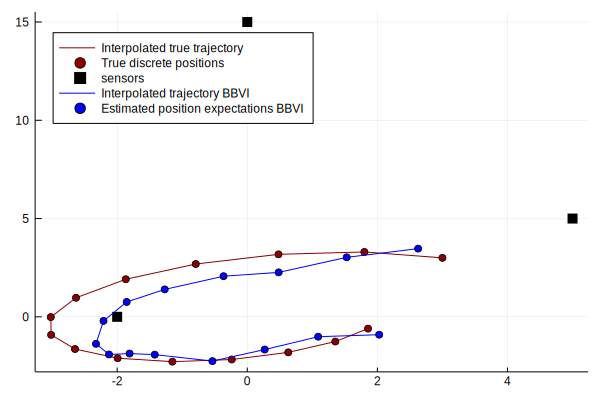

In [24]:
infer_plot = zeros(2,T)
for t=1:T
    infer_plot[:,t] = mean(q_z[t])[1:2]
end
plot(position[1,:],position[2,:],color=:redsblues,legend=:topright, label="Interpolated true trajectory")
plot!(position[1,:],position[2,:], seriestype = :scatter,color=:redsblues, label="True discrete positions")
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square, label="sensors")
plot!(infer_plot[1,:],infer_plot[2,:],color=:blue,legend=:topleft, label="Interpolated trajectory BBVI")
plot!(infer_plot[1,:],infer_plot[2,:], seriestype = :scatter,color=:blue, label="Estimated position expectations BBVI")

In [22]:
writedlm("BBVI_FE_x.txt", BBVI_FE_x)
writedlm("BBVI_FE_y.txt", BBVI_FE_y)
writedlm("BBVI_q_z_mean.txt", infer_plot)

In [23]:
@show infer_plot;

infer_plot = [2.62587 1.52832 0.482552 -0.36466 -1.26913 -1.85397 -2.21009 -2.32506 -2.12572 -1.80906 -1.42222 -0.535568 0.268075 1.08995 2.02801; 3.4703 3.02733 2.26128 2.06718 1.39581 0.756774 -0.208399 -1.37345 -1.91539 -1.86813 -1.92476 -2.25249 -1.66458 -1.01137 -0.909201]


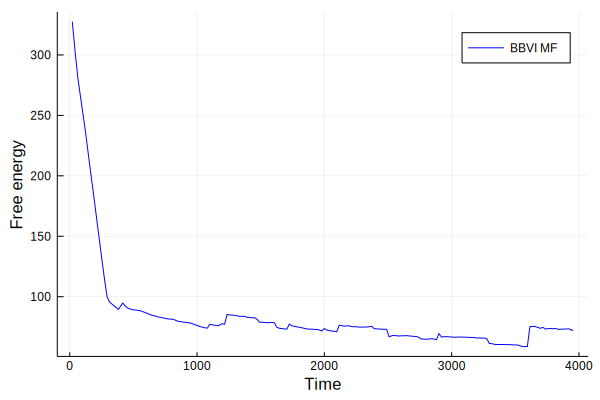

In [21]:
# Plot free energy over time
plot(BBVI_FE_x, BBVI_FE_y, color=:blue, label="BBVI MF", xlabel = "Time", ylabel = "Free energy")